## Import libraries


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

import os
import argparse
import pickle
import timeit

from torch._utils import _accumulate
import torch.utils.data as data_utils
from torch.utils.data import Subset
import torch.nn.utils.clip_grad as clip_grad
import torch.optim.lr_scheduler as lr_scheduler

import copy
from subprocess import call

## Load data

In [2]:
print("")

print("Downloading...")
if not os.path.exists("UCI HAR Dataset.zip"):
    call(
        'wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"',
        shell=True
    )
    print("Downloading done.\n")
else:
    print("Dataset already downloaded. Did not download twice.\n")


print("Extracting...")
extract_directory = os.path.abspath("UCI HAR Dataset")
if not os.path.exists(extract_directory):
    call(
        'unzip -nq "UCI HAR Dataset.zip"',
        shell=True
    )
    print("Extracting successfully done to {}.".format(extract_directory))
else:
    print("Dataset already extracted. Did not extract twice.\n")


Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.



In [3]:
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

TRAIN = "train/"
TEST = "test/"
DATASET_PATH = "/content/UCI HAR Dataset/"

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"
X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
print(X_train.shape)
test_data_count = len(X_test)  # 2947 testing series
print(test_data_count)
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))

train = data_utils.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True)

test = data_utils.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = data_utils.DataLoader(test, batch_size=1000, shuffle=True)

(7352, 128, 9)
2947
Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086


## Helper functions

In [4]:
#ADD NOISE TO HAR

noise_pair_45= np.array([[.55,0.45,0.0,0.0,0.0,0.0],
                        [0.0,.55,0.45,0.0,0.0,0.0],
                        [0.0,0.0,.55,0.45,0.0,0.0],
                        [0.0,0.0,0.0,.55,0.45,0.0],
                        [0.0,0.0,0.0,0.0,.55,0.0],
                        [0.45,0.0,0.0,0.0,0.0,.55]])
noise_sym_50 = np.array([[.50,.10,.10,.10,.10,.10],
                        [.10,.50,.10,.10,.10,.10],
                        [.10,.10,.50,.10,.10,.10],
                        [.10,.10,.10,.50,.10,.10],
                        [.10,.10,.10,.10,.50,.0],
                        [.10,.10,.10,.10,.10,.50]])

noise_sym_25 = np.array([[.25,.15,.15,.15,.15,.15],
                        [.15,.25,.15,.15,.15,.15],
                        [.15,.15,.25,.15,.15,.15],
                        [.15,.15,.15,.25,.15,.15],
                        [.15,.15,.15,.15,.25,.15],
                        [.15,.15,.15,.15,.15,.25]])

def flip_HAR_labels(array, noise_matrix):
    flipped = []
    for elem in array.flatten():
      flipped.append(np.random.choice([0,1,2,3,4,5], p=noise_matrix[int(elem)]))
    
    flipped = np.array(flipped)
    flipped.reshape((-1, 1))
    return flipped


def flip_HAR_labels_basic(array, flip_probability):
    flip_mask = np.random.binomial(1, flip_probability, len(array))
    flipped = []
    for i in range(len(array)):
        if flip_mask[i]==1:
            options = [0.0,1.0,2.0,3.0,4.0,5.0]
            new_options = [x for x in options if x != array[i]]
            flipped.append(np.random.choice(new_options, p=[0.2,0.2,0.2,0.2, 0.2]))
        else:
            flipped.append(array[i])
    
    flipped = np.array(flipped, dtype=np.int)
    flipped.reshape((-1, 1))
    return flipped

In [5]:
array = np.array([0.0,1.0,2.0,3.0,4.0,5.0])
noise_matrix = noise_sym_25

flip_HAR_labels_basic(array, 0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


array([0, 1, 2, 3, 4, 5])

In [6]:
flip_HAR_labels(array, noise_matrix)

array([3, 5, 1, 0, 1, 5])

In [7]:
flip_mask = np.random.binomial(1, 0.5, len(array))
flip_mask

array([1, 1, 1, 0, 1, 0])

In [8]:
def get_device():
    """Get a gpu if available."""
    if torch.cuda.device_count()>0:
        device = torch.device('cuda')
        print("Connected to a GPU")
    else:
        print("Using the CPU")
        device = torch.device('cpu')
    return device

def which_device(model):
    return next(model.parameters()).device


def add_channels(X):
    if len(X.shape) == 2:
        return X.reshape(X.shape[0], 1, X.shape[1],1)

    elif len(X.shape) == 3:
        return X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

    else:
        return "dimenional error"
    
def exp_lr_scheduler(epoch, optimizer, strategy='normal', decay_eff=0.1, decayEpoch=[]):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""

    if strategy=='normal':
        if epoch in decayEpoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= decay_eff
            print('New learning rate is: ', param_group['lr'])
    else:
        print('wrong strategy')
        raise ValueError('A very specific bad thing happened.')

    return optimizer

    
    
def gaussian_init_(n_units, std=1):    
    sampler = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([std/n_units]))
    A_init = sampler.sample((n_units, n_units))[..., 0]  
    return A_init

## Model

In [9]:
class NoisyRNN(nn.Module):
    def __init__(self, input_dim, output_classes, n_units=128, eps=0.01, 
                 beta=0.8, gamma_A=0.01, gamma_W=0.01, init_std=1, alpha=1,
                 solver='base', add_noise=0, mult_noise=0):
        super(NoisyRNN, self).__init__()

        self.device = get_device()


        self.n_units = n_units
        self.eps = eps
        self.solver = solver
        self.beta = beta
        self.alpha = alpha
        self.gamma_A = gamma_A
        self.gamma_W = gamma_W
        self.add_noise = add_noise
        self.mult_noise = mult_noise
        
        self.tanh = nn.Tanh()

        self.E = nn.Linear(input_dim, n_units)
        self.D = nn.Linear(n_units, output_classes)     
                                            
        self.C = nn.Parameter(gaussian_init_(n_units, std=init_std))            
        self.B = nn.Parameter(gaussian_init_(n_units, std=init_std))    
        self.I = torch.eye(n_units).to(self.device)   

        self.d = nn.Parameter(torch.rand(self.n_units).float().to(self.device)*0 + eps)           


    def forward(self, x, mode='test'):
        T = x.shape[1]
        h = torch.zeros(x.shape[0], self.n_units).to(which_device(self))

        for i in range(T):
            z = self.E(x[:,i,:])

            if i == 0:
                    A = self.beta * (self.B - self.B.transpose(1, 0)) + (1-self.beta) * (self.B + self.B.transpose(1, 0)) - self.gamma_A * self.I
                    W = self.beta * (self.C - self.C.transpose(1, 0)) + (1-self.beta) * (self.C + self.C.transpose(1, 0)) - self.gamma_W * self.I
                
                        
            add_noise = 0.0
            mult_noise = 1.0
            if mode == 'train':
                if self.add_noise > 0:
                    add_noise = self.add_noise * torch.randn(h.shape[0], h.shape[1]).float().to(self.device)
                            
                if self.mult_noise > 0:
                    #mult_noise = self.mult_noise * torch.randn(h.shape[0], h.shape[1]).float().to(self.device) + 1
                    mult_noise = self.mult_noise * torch.rand(h.shape[0], h.shape[1]).float().to(self.device) + (1-self.mult_noise)
                        

            if self.solver == 'base': 
                h_update = self.alpha * torch.matmul(h, A) + self.tanh(torch.matmul(h, W) + z)                
                h = h + self.eps * h_update
            elif self.solver == 'noisy':
                h_update = self.alpha * torch.matmul(h, A) + self.tanh(torch.matmul(h, W) + z)                
                h = h + self.d * mult_noise * h_update + add_noise                              
                 
                
        # Decoder 
        #----------
        out = self.D(h)
        return out

In [24]:
#code for the driver

parser = argparse.ArgumentParser(description='Human Activity Data')
#
parser.add_argument('-f')
#
parser.add_argument('--name', type=str, default='HAR', metavar='N', help='dataset')
#
parser.add_argument('--batch-size', type=int, default=128, metavar='N', help='input batch size for training (default: 128)')
#
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N', help='input batch size for testing (default: 1000)')
#
parser.add_argument('--epochs', type=int, default=100, metavar='N', help='number of epochs to train (default: 90)')
#
parser.add_argument('--lr', type=float, default=0.0015, metavar='LR', help='learning rate (default: 0.1)')
#
parser.add_argument('--lr_decay', type=float, default=0.1, help='learning rate decay value (default: 0.1)')
#
parser.add_argument('--lr_decay_epoch', type=int, nargs='+', default=[30], help='decrease learning rate at these epochs.')
#
parser.add_argument('--wd', default=0.0, type=float, metavar='W', help='weight decay (default: 0.0)')
#
parser.add_argument('--gamma_W', default=0.001, type=float, metavar='W', help='diffiusion rate for W')
#
parser.add_argument('--gamma_A', default=0.001, type=float, metavar='W', help='diffiusion rate for A')
#
parser.add_argument('--beta', default=0.75, type=float, metavar='W', help='skew level')
#
parser.add_argument('--model', type=str, default='NoisyRNN', metavar='N', help='model name')
#
parser.add_argument('--solver', type=str, default='noisy', metavar='N', help='model name')
#
parser.add_argument('--n_units', type=int, default=64, metavar='S', help='number of hidden units')
#
parser.add_argument('--eps', default=0.1, type=float, metavar='W', help='time step for euler scheme')
#
parser.add_argument('--T', default=49, type=int, metavar='W', help='time steps')
#
parser.add_argument('--init_std', type=float, default=0.1, metavar='S', help='control of std for initilization')
#
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 0)')
#
parser.add_argument('--gclip', type=int, default=0, metavar='S', help='gradient clipping')
#
parser.add_argument('--optimizer', type=str, default='Adam', metavar='N', help='optimizer')
#
parser.add_argument('--alpha', type=float, default=1, metavar='S', help='for ablation study')
#
parser.add_argument('--add_noise', type=float, default=0.0, metavar='S', help='level of additive noise')
#
parser.add_argument('--mult_noise', type=float, default=0.0, metavar='S', help='level of multiplicative noise')
#
args = parser.parse_args()

if not os.path.isdir(args.name + '_results'):
    os.mkdir(args.name + '_results')

#==============================================================================
# set random seed to reproduce the work
#==============================================================================
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

#==============================================================================
# get device
#==============================================================================
device = get_device()

#==============================================================================
# initialize model
#==============================================================================
seeds = [1, 2, 3]


def driver(seed, train, test, nrnn = False):

  final_acc = []
  model = NoisyRNN(input_dim=int(9), output_classes=6, n_units=args.n_units, 
                eps=args.eps, beta=args.beta, gamma_A=args.gamma_A, gamma_W=args.gamma_W,
                init_std=args.init_std, alpha=args.alpha,  solver=args.solver, 
                add_noise=args.add_noise, mult_noise=args.mult_noise).to(device)

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  noise = torch.randn(1,7352,128,9).float()


  #==============================================================================
  # set random seed to reproduce the work
  #==============================================================================
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)


  #==============================================================================
  # Model summary
  #==============================================================================
  print(model)    
  print('**** Setup ****')
  print('Total params: %.2fk' % (sum(p.numel() for p in model.parameters())/1000.0))
  print('************')    
    

  if args.optimizer == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.wd)
  elif  args.optimizer == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
  else:
      print("Unexpected optimizer!")
      raise 


  loss_func = nn.CrossEntropyLoss().to(device)

  # training and testing
  count = 0
  loss_hist = []
  test_acc = []

  t0 = timeit.default_timer()
  for epoch in range(args.epochs):
      model.train()
      lossaccum = 0
      
      for step, (x, y) in enumerate(train):
          count += 1
          
          # Reshape data for recurrent unit
          inputs = Variable(x.view(-1, 128, int(9))).to(device) # reshape x to (batch, time_step, input_size)         
          targets = Variable(y).to(device) 

                  
          # send data to recurrent unit    
          output = model(inputs, mode='train') 
          loss = loss_func(output, targets.squeeze(1).long())
          
          
          optimizer.zero_grad()
          loss.backward()          
          
          if args.gclip != 0.0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), args.gclip) # gradient clip
              
          optimizer.step() # update weights
          lossaccum += loss.item()

          if args.model == 'test':
              D = model.W.weight.data.cpu().numpy()  
              u, s, v = np.linalg.svd(D, 0)
              model.W.weight.data = torch.from_numpy(u.dot(v)).float().cuda()

      loss_hist.append(lossaccum)    
      
      if epoch % 1 == 0:
          model.eval()
          correct = 0
          total_num = 0
          for data, target in test: 
              data, target = data.to(device), target.to(device)                
              output = model(data.view(-1, 128, int(9)))
              
              pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                   
              correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
              total_num += len(data)
          
          accuracy = correct / total_num
          test_acc.append(accuracy)
          print('Epoch: ', epoch, 'Iteration: ', count, '| train loss: %.4f' % loss.item(), '| test accuracy: %.3f' % accuracy)


      if nrnn == True:
          B = model.B.data.cpu().numpy()            
          A = args.alpha * (args.beta * (B - B.T) + (1-args.beta) * (B + B.T) - args.gamma_A * np.eye(args.n_units))
          A = 0.5 * (A + A.T)
          e, _ = np.linalg.eig(A)
          # print('Eigenvalues of A (min and max): ', (np.min(np.abs(e)), np.max(np.abs(e))))
          
          C = model.C.data.cpu().numpy()            
          W = args.beta * (C - C.T) + (1-args.beta) * (C + C.T) - args.gamma_W * np.eye(args.n_units)
          e, _ = np.linalg.eig(W)
          # print('Eigenvalues of A (min and max): ', (np.min(np.abs(e)), np.max(np.abs(e))))
              
              

      # schedule learning rate decay    
      optimizer=exp_lr_scheduler(epoch, optimizer, decay_eff=args.lr_decay, decayEpoch=args.lr_decay_epoch)

  print('total time: ', timeit.default_timer()  - t0 )

  final_acc.append(max(test_acc))

  torch.save(model, args.name + '_results/' + args.model + '_' + args.name + '_T_' + str(args.T) 
              + '_units_' + str(args.n_units) + '_beta_' + str(args.beta) 
              + '_gamma_A_' + str(args.gamma_A) + '_gamma_W_' + str(args.gamma_W) + '_eps_' + str(args.eps) 
              + '_solver_' + str(args.solver) + '_gclip_' + str(args.gclip) + '_optimizer_' + str(args.optimizer)
              + '_addnoise_' + str(args.add_noise) + '_multnoise_' + str(args.mult_noise) 
              + '_seed_' + str(args.seed) + '.pkl')  

  data = {'loss': lossaccum, 'testacc': test_acc}
  f = open(args.name + '_results/' + args.model + '_' + args.name + '_T_' + str(args.T) 
              + '_units_' + str(args.n_units) + '_beta_' + str(args.beta) 
              + '_gamma_A_' + str(args.gamma_A) + '_gamma_W_' + str(args.gamma_W) + '_eps_' + str(args.eps) 
              + '_solver_' + str(args.solver) + '_gclip_' + str(args.gclip) + '_optimizer_' + str(args.optimizer)
              + '_addnoise_' + str(args.add_noise) + '_multnoise_' + str(args.mult_noise) 
              + '_seed_' + str(args.seed) + '_loss.pkl',"wb")

  pickle.dump(data,f)
  f.close()
  return max(test_acc)

Using the CPU


Using the CPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=9, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=6, bias=True)
)
**** Setup ****
Total params: 9.29k
************
Epoch:  0 Iteration:  58 | train loss: 1.0199 | test accuracy: 0.529
Epoch:  1 Iteration:  116 | train loss: 0.8434 | test accuracy: 0.605
Epoch:  2 Iteration:  174 | train loss: 0.6489 | test accuracy: 0.590
Epoch:  3 Iteration:  232 | train loss: 0.4747 | test accuracy: 0.664
Epoch:  4 Iteration:  290 | train loss: 0.3670 | test accuracy: 0.767
Epoch:  5 Iteration:  348 | train loss: 0.3122 | test accuracy: 0.770
Epoch:  6 Iteration:  406 | train loss: 0.1784 | test accuracy: 0.749
Epoch:  7 Iteration:  464 | train loss: 0.3391 | test accuracy: 0.745
Epoch:  8 Iteration:  522 | train loss: 0.4290 | test accuracy: 0.816
Epoch:  9 Iteration:  580 | train loss: 0.3400 | test accuracy: 0.819
Epoch:  10 Iteration:  638 | train loss: 0.3817 | test accuracy: 0.828
Epoch:  11 Iteration:  6

{'boxes': [<matplotlib.lines.Line2D at 0x7f587a85a890>],
 'caps': [<matplotlib.lines.Line2D at 0x7f587a82c950>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f587a833990>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f587a833450>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f587a85ae90>,
  <matplotlib.lines.Line2D at 0x7f587a82c410>]}

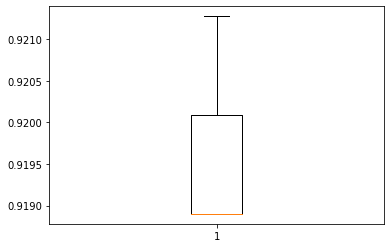

In [12]:
final_acc = []
for seed in seeds:
  max_acc = driver(seed, train_loader, test_loader)
  final_acc.append(max_acc)
print(final_acc)
plt.boxplot(final_acc)

## Experiment with flipped labels (baseline model)

Using the CPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=9, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=6, bias=True)
)
**** Setup ****
Total params: 9.29k
************
Epoch:  0 Iteration:  58 | train loss: 1.8315 | test accuracy: 0.165
Epoch:  1 Iteration:  116 | train loss: 1.8175 | test accuracy: 0.181
Epoch:  2 Iteration:  174 | train loss: 1.8309 | test accuracy: 0.172
Epoch:  3 Iteration:  232 | train loss: 1.7702 | test accuracy: 0.199
Epoch:  4 Iteration:  290 | train loss: 1.8257 | test accuracy: 0.199
Epoch:  5 Iteration:  348 | train loss: 1.8567 | test accuracy: 0.194
Epoch:  6 Iteration:  406 | train loss: 1.7743 | test accuracy: 0.185
Epoch:  7 Iteration:  464 | train loss: 1.8001 | test accuracy: 0.189
Epoch:  8 Iteration:  522 | train loss: 1.7443 | test accuracy: 0.193
Epoch:  9 Iteration:  580 | train loss: 1.7148 | test accuracy: 0.197
Epoch:  10 Iteration:  638 | train loss: 1.7643 | test accuracy: 0.190
Epoch:  11 Iteration:  6

{'boxes': [<matplotlib.lines.Line2D at 0x7f5877c58e50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5877c46f10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5877c59f90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5877c59a50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5877c46490>,
  <matplotlib.lines.Line2D at 0x7f5877c469d0>]}

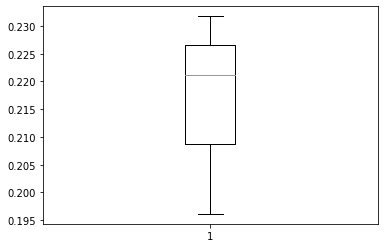

In [17]:
final_acc_2 = []
for seed in seeds:
  np.random.seed(seed)

  y_train_flipped = flip_HAR_labels(y_train, noise_matrix).reshape(-1, 1)
  y_test_flipped = flip_HAR_labels(y_test, noise_matrix).reshape(-1, 1)

  train_flipped = data_utils.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train_flipped))
  train_flipped_loader = data_utils.DataLoader(train_flipped, batch_size=128, shuffle=True)

  test_flipped = data_utils.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_flipped))
  test_flipped_loader = data_utils.DataLoader(test_flipped, batch_size=1000, shuffle=True)

  max_acc = driver(seed, train_flipped_loader, test_flipped_loader)
  final_acc_2.append(max_acc)
print(final_acc_2)
plt.boxplot(final_acc_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


Using the CPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=9, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=6, bias=True)
)
**** Setup ****
Total params: 9.29k
************
Epoch:  0 Iteration:  58 | train loss: 1.3821 | test accuracy: 0.496
Epoch:  1 Iteration:  116 | train loss: 1.2551 | test accuracy: 0.494
Epoch:  2 Iteration:  174 | train loss: 1.3664 | test accuracy: 0.554
Epoch:  3 Iteration:  232 | train loss: 0.9597 | test accuracy: 0.601
Epoch:  4 Iteration:  290 | train loss: 0.8033 | test accuracy: 0.659
Epoch:  5 Iteration:  348 | train loss: 0.9751 | test accuracy: 0.635
Epoch:  6 Iteration:  406 | train loss: 0.7702 | test accuracy: 0.660
Epoch:  7 Iteration:  464 | train loss: 0.9179 | test accuracy: 0.662
Epoch:  8 Iteration:  522 | train loss: 0.5647 | test accuracy: 0.728
Epoch:  9 Iteration:  580 | train loss: 0.8258 | test accuracy: 0.736
Epoch:  10 Iteration:  638 | train loss: 0.7464 | test accuracy: 0.735
Epoch:  11 Iteration:  6

{'boxes': [<matplotlib.lines.Line2D at 0x7f587aae7e90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f587aaeff50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f587aadffd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f587aadfa90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f587aaef4d0>,
  <matplotlib.lines.Line2D at 0x7f587aaefa10>]}

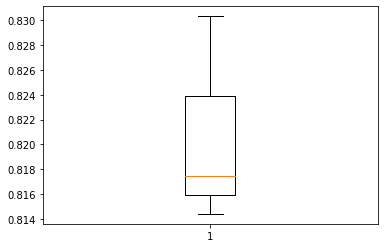

In [19]:
final_acc_3 = []
for seed in seeds:
  np.random.seed(seed)

  y_train_flipped = flip_HAR_labels_basic(y_train, flip_probability = 0.1).reshape(-1, 1)
  y_test_flipped = flip_HAR_labels_basic(y_test, flip_probability = 0.1).reshape(-1, 1)

  train_flipped = data_utils.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train_flipped))
  train_flipped_loader = data_utils.DataLoader(train_flipped, batch_size=128, shuffle=True)

  test_flipped = data_utils.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_flipped))
  test_flipped_loader = data_utils.DataLoader(test_flipped, batch_size=1000, shuffle=True)

  max_acc = driver(seed, train_flipped_loader, test_flipped_loader)
  final_acc_3.append(max_acc)
print(final_acc_3)
plt.boxplot(final_acc_3)

## Experiment with flipped labels (Noisy RNN)

Using the CPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=9, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=6, bias=True)
)
**** Setup ****
Total params: 9.29k
************
Epoch:  0 Iteration:  58 | train loss: 1.0190 | test accuracy: 0.503
Epoch:  1 Iteration:  116 | train loss: 0.7859 | test accuracy: 0.570
Epoch:  2 Iteration:  174 | train loss: 0.7660 | test accuracy: 0.530
Epoch:  3 Iteration:  232 | train loss: 0.5363 | test accuracy: 0.597
Epoch:  4 Iteration:  290 | train loss: 0.5567 | test accuracy: 0.785
Epoch:  5 Iteration:  348 | train loss: 0.5405 | test accuracy: 0.806
Epoch:  6 Iteration:  406 | train loss: 0.2864 | test accuracy: 0.816
Epoch:  7 Iteration:  464 | train loss: 0.2804 | test accuracy: 0.797
Epoch:  8 Iteration:  522 | train loss: 0.3531 | test accuracy: 0.805
Epoch:  9 Iteration:  580 | train loss: 0.4456 | test accuracy: 0.813
Epoch:  10 Iteration:  638 | train loss: 0.3382 | test accuracy: 0.846
Epoch:  11 Iteration:  6

{'boxes': [<matplotlib.lines.Line2D at 0x7f58780f7110>],
 'caps': [<matplotlib.lines.Line2D at 0x7f58781004d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f587b1fc590>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f587b1fcc10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f58780fa550>,
  <matplotlib.lines.Line2D at 0x7f5877c48a90>]}

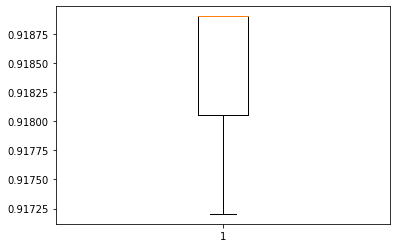

In [25]:
final_acc_4 = []
for seed in seeds:
  max_acc = driver(seed, train_loader, test_loader, nrnn = True)
  final_acc_4.append(max_acc)
print(final_acc_4)
plt.boxplot(final_acc_4)